# Класс матриц

In [2]:
class Matrix:
    def __init__(self, matrix=None, vector_orientation='row'):
        if matrix is None:
            self.matrix = self.input_from_keyboard()
        elif isinstance(matrix, list):
            if all(isinstance(x, (int, float)) for x in matrix):
                if vector_orientation == 'row':
                    self.matrix = [matrix]
                elif vector_orientation == 'col':
                    self.matrix = [[x] for x in matrix]
                else:
                    raise ValueError("vector_orientation должен быть 'row' или 'col'")
            else:
                self.matrix = matrix
        # elif isinstance(matrix, np.ndarray):
        #     self.matrix = matrix
        else:
            raise ValueError("неподдерживаемый тип данных для инициализации матрицы")

    @classmethod
    def input_from_keyboard(cls):
        try:
            rows = int(input("Введите кол-во строк: "))
            cols = int(input("Введите кол-во столбцов: "))
            if rows <= 0 or cols <= 0:
                raise ValueError("кол-во строк и столбцов должны быть положительными")
        except ValueError as e:
            print(f"Input error: {e}")
            exit(1)

        print("Введите матрицу построчно, элементы отделяйте пробелами:")
        matrix = []
        for i in range(rows):
            try:
                row = list(map(float, input(f"Row {i+1}: ").split()))
                if len(row) != cols:
                    raise ValueError(f"Ожидалось {cols} элементов, получили {len(row)}.")
                matrix.append(row)
            except ValueError as e:
                print(f"Input error: {e}")
                exit(1)

        return matrix

    def __add__(self, other):
        if isinstance(other, Matrix):
            if len(self.matrix) != len(other.matrix) or len(self.matrix[0]) != len(other.matrix[0]):
                raise ValueError("разные размерности матриц, проверь что-то не так")
            result = [
                [self.matrix[i][j] + other.matrix[i][j] for j in range(len(self.matrix[0]))]
                for i in range(len(self.matrix))
            ]
            return Matrix(result)
        else:
            raise ValueError("тока с другой матрицей сложить можем")

    def __sub__(self, other):
        if isinstance(other, Matrix):
            if len(self.matrix) != len(other.matrix) or len(self.matrix[0]) != len(other.matrix[0]):
                raise ValueError("разные размерности матриц, проверь что-то не так")
            result = [
                [self.matrix[i][j] - other.matrix[i][j] for j in range(len(self.matrix[0]))]
                for i in range(len(self.matrix))
            ]
            return Matrix(result)
        else:
            raise ValueError("можем вычитать из матрицы матрицу, у тебя не так")

    def __mul__(self, scalar):
        if isinstance(scalar, (int, float)):
            result = [
                [self.matrix[i][j] * scalar for j in range(len(self.matrix[0]))]
                for i in range(len(self.matrix))
            ]
            return Matrix(result)
        else:
            raise ValueError("матрица может быть умножена только на скаляр")

    def __rmul__(self, scalar):
        return self.__mul__(scalar)

    def __matmul__(self, other):
        if isinstance(other, Matrix):
            if len(self.matrix[0]) != len(other.matrix):
                raise ValueError("не те размерности для перемножения матриц")

            result = []
            for i in range(len(self.matrix)):
                row = []
                for j in range(len(other.matrix[0])):
                    element = sum(self.matrix[i][k] * other.matrix[k][j] for k in range(len(other.matrix)))
                    row.append(element)
                result.append(row)
            return Matrix(result)
        else:
            raise ValueError("могу только с другой матрицей перемножить")

    def __truediv__(self, scalar):
      if isinstance(scalar, (int, float)):
          if scalar == 0:
              raise ZeroDivisionError("на ноль не делим")
          result = [
              [self.matrix[i][j] / scalar for j in range(len(self.matrix[0]))]
              for i in range(len(self.matrix))
          ]
          return Matrix(result)
      else:
          raise ValueError("может быть разделена только на скаляр")

    def __str__(self):
      all_elements = [elem for row in self.matrix for elem in row]
      max_width = max(len(f"{elem:.2f}") for elem in all_elements)

      rows = ['[' + ' '.join(f"{elem:>{max_width}.2f}" for elem in row) + ']'
          for row in self.matrix]
      return '[' + '\n '.join(rows) + ']'

    def __getitem__(self, index):
      return self.matrix[index]

    def __setitem__(self, index, value):
      self.matrix[index] = value


## Функции для формирования матриц (как в numpy)

In [3]:
def get_eye_matrix(shape):
    rows, cols = shape
    return [[1 if i == j else 0 for j in range(cols)] for i in range(rows)]


def my_full(shape, fill_value):
    return [[fill_value for _ in range(shape[1])] for _ in range(shape[0])]


def get_arange_matrix(shape, start=0, step=1):
    rows, cols = shape
    array = []
    current_value = start
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(current_value)
            current_value += step
        array.append(row)
    return array

# Уровень Easy

## 1. Метод Гаусса для решения СЛАУ

In [4]:
from typing import List

def gauss_solver(A: 'Matrix', b: 'Matrix') -> List['Matrix']:
    n = len(A.matrix)
    m = len(A.matrix[0])

    aug = Matrix([[A[i][j] for j in range(m)] + [b[i][0]] for i in range(n)])

    row = 0
    for col in range(m):
        pivot = None
        for r in range(row, n):
            if aug[r][col] != 0:
                pivot = r
                break

        if pivot is None:
            continue

        aug[row], aug[pivot] = aug[pivot], aug[row]

        factor = aug[row][col]
        for j in range(col, m + 1):
            aug[row][j] /= factor

        for r in range(row + 1, n):
            factor = aug[r][col]
            for j in range(col, m + 1):
                aug[r][j] -= factor * aug[row][j]

        row += 1

    for r in range(row, n):
        if all(aug[r][c] == 0 for c in range(m)) and aug[r][m] != 0:
            raise ValueError("Система несовместна")

    lead_vars = [-1] * row
    for r in range(row):
        for c in range(m):
            if abs(aug[r][c]) > 1e-9:
                lead_vars[r] = c
                break

    free_vars = [c for c in range(m) if c not in lead_vars]

    if len(free_vars) == 0:
        solution = [0] * m
        for i in reversed(range(row)):
            idx = lead_vars[i]
            solution[idx] = aug[i][m] - sum(aug[i][j] * solution[j] for j in range(idx + 1, m))
        print("Единственное решение")
        return [Matrix([[x] for x in solution])]
    else:
        print("Бесконечное количество решений")
        return build_fundamental_solution(aug, lead_vars, free_vars, m)


def build_fundamental_solution(aug, lead_vars, free_vars, vars_count):
    basis = []
    for free_var in free_vars:
        vector = [0] * vars_count
        vector[free_var] = 1

        for i in reversed(range(len(lead_vars))):
            idx = lead_vars[i]
            if idx == -1:
                continue
            value = -sum(aug[i][j] * vector[j] for j in range(idx + 1, vars_count))
            vector[idx] = value

        basis.append(Matrix([[x] for x in vector]))
    return basis


## 2. Центрирование данных

In [5]:
def center_data(X):
    n = len(X.matrix)
    m = len(X.matrix[0])

    feature_means = [sum(X[i][j] for i in range(n)) / n for j in range(m)]
    X_centered = [[X[i][j] - feature_means[j] for j in range(m)] for i in range(n)]

    return Matrix(X_centered)

## 3. Матрица ковариаций

In [6]:
def transpose(matrix):
    n = len(matrix.matrix)
    m = len(matrix.matrix[0])
    transposed = [[matrix[i][j] for i in range(n)] for j in range(m)]
    return Matrix(transposed)


def covariance_matrix(X_centered):
    n = len(X_centered.matrix)
    XT = transpose(X_centered)
    C = (1/(n-1)) * (XT @ X_centered)
    return C

# Уровень Normal

## 1. Собственные значения матрицы через метод Гаусса и бисекцию

In [7]:
def find_eigenvalues(C: 'Matrix', tol: float = 1e-6) -> List[float]:
    n = len(C.matrix)

    def determinant_minus_lambda(lam: float) -> float:
        M = Matrix([[C[i][j] - (lam if i == j else 0) for j in range(n)] for i in range(n)])
        return compute_determinant_gauss(M)

    eigenvalues = []
    left, right = -10, 100
    step = 0.001

    x = left
    while x <= right:
        fx = determinant_minus_lambda(x)
        if abs(fx) < tol:
            eigenvalues.append(x)
            x += 5 * step
            continue

        x_next = x + step
        if x_next > right:
            break

        fx_next = determinant_minus_lambda(x_next)
        if fx * fx_next < 0:
            root = bisection(determinant_minus_lambda, x, x_next, tol)
            eigenvalues.append(root)
            x = x_next + 5 * step
            continue

        x = x_next

    eigenvalues = merge_close_roots(eigenvalues, eps=1e-2)

    return eigenvalues


def compute_determinant_gauss(M: 'Matrix') -> float:
    n = len(M.matrix)
    M = Matrix([[M[i][j] for j in range(n)] for i in range(n)])
    det = 1
    for i in range(n):
        if abs(M[i][i]) < 1e-12:
            for j in range(i + 1, n):
                if abs(M[j][i]) > 1e-12:
                    M[i], M[j] = M[j], M[i]
                    det *= -1
                    break
            else:
                return 0

        det *= M[i][i]
        for j in range(i + 1, n):
            factor = M[j][i] / M[i][i]
            for k in range(i, n):
                M[j][k] -= factor * M[i][k]
    return det


def bisection(f, a, b, tol):
    fa = f(a)
    fb = f(b)

    if abs(fa) < tol:
        return a
    if abs(fb) < tol:
        return b

    if fa * fb > 0:
        for _ in range(100):
            c = (a + b) / 2
            fc = f(c)
            if abs(fc) < tol or abs(b - a) < tol:
                return c
            if abs(fa) < abs(fb):
                b = c
                fb = fc
            else:
                a = c
                fa = fc
        return (a + b) / 2
    else:
        while b - a > tol:
            c = (a + b) / 2
            fc = f(c)
            if abs(fc) < tol:
                return c
            if fa * fc < 0:
                b = c
                fb = fc
            else:
                a = c
                fa = fc
        return (a + b) / 2


def merge_close_roots(roots: List[float], eps: float = 1e-3) -> List[float]:
    if not roots:
        return []

    roots.sort()
    merged = []
    current_group = [roots[0]]

    for root in roots[1:]:
        if abs(root - current_group[-1]) <= eps:
            current_group.append(root)
        else:
            merged.append(sum(current_group) / len(current_group))
            current_group = [root]

    merged.append(sum(current_group) / len(current_group))
    return merged

## 1. Собственные значения через QR разложение

In [8]:
import math

def qr_decomposition(A: 'Matrix'):
    n = len(A.matrix)
    m = len(A.matrix[0])

    Q_columns = []
    for j in range(m):
        v = [A[i][j] for i in range(n)]
        for k in range(j):
            qk = [Q_columns[k][i] for i in range(n)]
            proj = sum(v[i] * qk[i] for i in range(n))
            for i in range(n):
                v[i] -= proj * qk[i]
        norm = math.sqrt(sum(v[i] ** 2 for i in range(n)))
        if norm < 1e-12:
            v = [0] * n
        else:
            v = [v[i] / norm for i in range(n)]
        Q_columns.append(v)

    Q = Matrix([[Q_columns[j][i] for j in range(m)] for i in range(n)])
    R = Matrix([[0] * m for _ in range(m)])
    for i in range(m):
        for j in range(i, m):
            R[i][j] = sum(Q[k][i] * A[k][j] for k in range(n))

    return Q, R


def qr_algorithm(C: 'Matrix', max_iter: int = 10000, tol: float = 1e-7) -> List[float]:
    n = len(C.matrix)
    A = Matrix([row[:] for row in C.matrix])

    for _ in range(max_iter):
        Q, R = qr_decomposition(A)
        A = R @ Q

    eigenvalues = [A[i][i] for i in range(n)]
    return eigenvalues


## 2. Собственные векторы

In [9]:
def find_eigenvectors(C: 'Matrix', eigenvalues: List[float]) -> List['Matrix']:
    n = len(C.matrix)
    eigenvectors = []

    for lam in eigenvalues:
        M = Matrix([[C[i][j] - (lam if i == j else 0) for j in range(n)] for i in range(n)])

        vectors = solve_homogeneous_system(M)
        eigenvectors.extend(vectors)

    return eigenvectors


def solve_homogeneous_system(M: 'Matrix') -> List['Matrix']:
    n = len(M.matrix)
    m = len(M.matrix[0])

    M = Matrix([[M[i][j] for j in range(m)] for i in range(n)])
    pivot_cols = []
    row = 0
    for col in range(m):
        pivot_row = None
        for r in range(row, n):
            if abs(M[r][col]) > 1e-4:
                pivot_row = r
                break

        if pivot_row is not None:
            if pivot_row != row:
                M.matrix[row], M.matrix[pivot_row] = M.matrix[pivot_row], M.matrix[row]

            pivot_cols.append(col)

            factor = M.matrix[row][col]
            for j in range(col, m):
                M.matrix[row][j] /= factor

            for r in range(row + 1, n):
                factor = M.matrix[r][col]
                for j in range(col, m):
                    M.matrix[r][j] -= factor * M.matrix[row][j]

            row += 1

    free_vars = [i for i in range(m) if i not in pivot_cols]
    basis = []

    for free_var in free_vars:
        vec = [0] * m
        vec[free_var] = 1

        for i in range(len(pivot_cols) - 1, -1, -1):
            pivot_col = pivot_cols[i]
            variable_sum = 0
            for j in range(pivot_col + 1, m):
                variable_sum += M.matrix[i][j] * vec[j]
            vec[pivot_col] = -variable_sum

        basis.append(Matrix([[v] for v in vec]))

    return basis


## 3. Доля объясненной дисперсии

In [10]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    sorted_eigenvalues = sorted(eigenvalues, reverse=True)

    k_main = sum(sorted_eigenvalues[:k])
    all_eigenvalues = sum(sorted_eigenvalues)

    return k_main / all_eigenvalues

# Уровень Hard

## 1. Полный алгоритм PCA

In [11]:
def normalize_vector(v: 'Matrix') -> 'Matrix':
    norm = sum(x[0]**2 for x in v.matrix) ** 0.5
    if norm == 0:
        return v
    return v / norm


def pca(X:'Matrix', k: int):
    m = len(X.matrix[0])
    n = len(X.matrix)
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)

    eigenvalues = qr_algorithm(C)
    eigenvalues_sorted = sorted(eigenvalues, reverse=True)
    eigenvectors = find_eigenvectors(C, eigenvalues_sorted)
    eigenvectors = [normalize_vector(v) for v in eigenvectors]

    k_principal = [[] for _ in range(m)]
    for i, vector in enumerate(eigenvectors):
        if i >= k:
            break
        for elem in range(m):
            k_principal[elem].append(vector[elem][0])

    k_principal = Matrix(k_principal)
    X_proj = X_centered @ k_principal
    explained_variance = explained_variance_ratio(eigenvalues, k)

    return X_proj, explained_variance

In [12]:
data = [
    [2.5, 2.4, 1.2],
    [0.5, 0.7, 0.8],
    [2.2, 2.9, 1.4],
    [1.9, 2.2, 1.0],
    [3.1, 3.0, 1.5]
]

X = Matrix(data)
X_proj, explained_variance = pca(X, k=2)

print(X_proj)
print("\nДоля объяснённой дисперсии (explained_variance):", explained_variance)


[[ 0.44 -0.21]
 [-2.21 -0.04]
 [ 0.60  0.38]
 [-0.16  0.04]
 [ 1.33 -0.17]]

Доля объяснённой дисперсии (explained_variance): 0.9946121173266852


## 2. Проекция данных на две главные компоненты

In [13]:
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

def plot_pca_projection(X_proj: 'Matrix') -> Figure:
    if len(X_proj.matrix[0]) != 2:
        raise ValueError("Проекция должна быть двумерной (n×2) для построения графика.")

    fig, ax = plt.subplots()

    x_coords = [row[0] for row in X_proj.matrix]
    y_coords = [row[1] for row in X_proj.matrix]

    ax.scatter(x_coords, y_coords, c='blue', edgecolors='k')
    ax.set_xlabel('1-ая главная компонента (PC1)')
    ax.set_ylabel('2-ая главная компонента (PC2)')
    ax.set_title('Проекция на первые две главные компоненты')
    ax.grid(True)

    return fig

Проекция данных:
[[-13.73   5.50]
 [ -4.17   0.91]
 [  5.16   7.56]
 [-10.59   0.98]
 [ 13.50   0.90]
 [ -4.07   4.88]
 [ 10.89  -0.53]
 [  3.27  -6.70]
 [ -4.52  -1.07]
 [  3.86  -5.49]
 [ -3.03  -7.95]
 [ -8.12   2.67]
 [ -2.74   5.50]
 [ -0.02 -13.38]
 [ -6.43   4.79]
 [  2.05   5.54]
 [  9.37   8.37]
 [ -0.15  -9.81]
 [ -2.03  -6.29]
 [ 11.52   3.62]]

Доля объяснённой дисперсии двумя компонентами: 0.5828


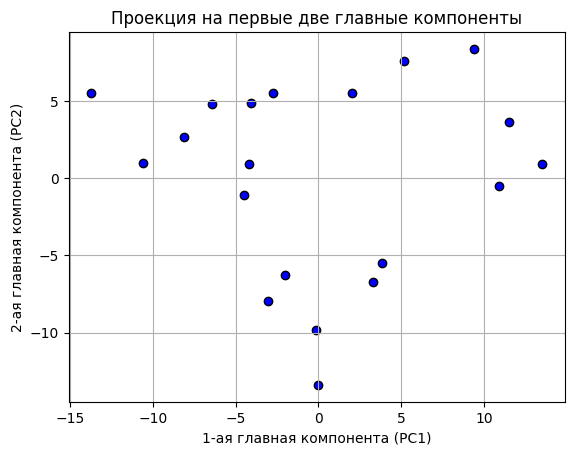

In [14]:
import random

random.seed(2)
data = [[random.uniform(-10, 10) for _ in range(5)] for _ in range(20)]
X = Matrix(data)

X_proj, explained_variance = pca(X, k=2)

print(f"Проекция данных:\n{X_proj}")
print()
print(f"Доля объяснённой дисперсии двумя компонентами: {explained_variance:.4f}")

fig = plot_pca_projection(X_proj)
fig.show()

## 3. Среднеквадратическая ошибка восстановления данных

In [15]:
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:
    n = len(X_orig.matrix)
    m = len(X_orig.matrix[0])
    error_sum = 0

    for i in range(n):
        for j in range(m):
            diff = X_orig[i][j] - X_recon[i][j]
            error_sum += diff ** 2

    mse = error_sum / (n * m)
    return mse


## Восстановление матрицы через главные компоненты и вектор средних значений

In [16]:
def reconstruct_data(X_proj, W, mean_vector):
    WT = transpose(W)
    X_recon_centered = X_proj @ WT

    n = len(X_recon_centered.matrix)
    m = len(X_recon_centered.matrix[0])
    X_recon = Matrix([[X_recon_centered[i][j] + mean_vector[j] for j in range(m)] for i in range(n)])

    return X_recon

# Уровень Expert

## 1. Выбор числа главных комопонент на основе порога объясненной дисперсии

In [17]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    all_eigenvalues = sum(eigenvalues)
    explained = 0
    for k, value in enumerate(eigenvalues, start=1):
        explained += value
        if explained / total_variance >= threshold:
            return k
    return len(eigenvalues)


## PCA с автоматическим выбором числа компанент на основе объясненной дисперсии

In [18]:
def automated_pca(X:'Matrix', threshold):
    m = len(X.matrix[0])
    n = len(X.matrix)
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)

    eigenvalues = qr_algorithm(C)
    eigenvalues_sorted = sorted(eigenvalues, reverse=True)
    eigenvectors = find_eigenvectors(C, eigenvalues_sorted)
    eigenvectors = [normalize_vector(v) for v in eigenvectors]

    k = auto_select_k(eigenvalues_sorted, threshold)

    k_principal = [[] for _ in range(m)]
    for i, vector in enumerate(eigenvectors):
        if i >= k:
            break
        for elem in range(m):
            k_principal[elem].append(vector[elem][0])

    k_principal = Matrix(k_principal)
    X_proj = X_centered @ k_principal
    explained_variance = explained_variance_ratio(eigenvalues, k)

    return X_proj, explained_variance

## Правило сломанной трости для вычисления числа главных компонент и PCA, использующий данное правило

In [19]:
def broken_stick_rule(eigenvalues):
    m = len(eigenvalues)
    all_eigenvalues = sum(eigenvalues)
    explained_ratios = [eig / all_eigenvalues for eig in eigenvalues]

    broken_stick = []
    for k in range(1, m + 1):
        expected = sum(1/i for i in range(k, m + 1)) / m
        broken_stick.append(expected)

    k_optimal = 0
    for ratio, stick in zip(explained_ratios, broken_stick):
        if ratio >= stick:
            k_optimal += 1
        else:
            break

    return k_optimal


def pca_broken_stick(X:'Matrix'):
    m = len(X.matrix[0])
    n = len(X.matrix)
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)

    eigenvalues = qr_algorithm(C)
    eigenvalues_sorted = sorted(eigenvalues, reverse=True)
    eigenvectors = find_eigenvectors(C, eigenvalues_sorted)
    eigenvectors = [normalize_vector(v) for v in eigenvectors]

    k = broken_stick_rule(eigenvalues_sorted)

    k_principal = [[] for _ in range(m)]
    for i, vector in enumerate(eigenvectors):
        if i >= k:
            break
        for elem in range(m):
            k_principal[elem].append(vector[elem][0])

    k_principal = Matrix(k_principal)
    X_proj = X_centered @ k_principal
    explained_variance = explained_variance_ratio(eigenvalues, k)

    return X_proj, explained_variance


## 2. Обработка пропущенных значений в данных

In [20]:
import math

def handle_missing_values(X: 'Matrix') -> 'Matrix':
    n = len(X.matrix)
    m = len(X.matrix[0])

    mean_vector = [
        sum(X[i][j] for i in range(n) if X[i][j] is not None and not math.isnan(X[i][j])) /
        sum(1 for i in range(n) if X[i][j] is not None and not math.isnan(X[i][j]))
        for j in range(m)
    ]

    X_filled = [
        [
            mean_vector[j] if (X[i][j] is None or (isinstance(X[i][j], float) and math.isnan(X[i][j]))) else X[i][j]
            for j in range(m)
        ]
        for i in range(n)
    ]

    return Matrix(X_filled)


In [21]:
X_data = Matrix([
    [1.0, 2.0, None],
    [2.0, math.nan, 5.0],
    [None, 4.0, 6.0],
    [4.0, 5.0, 6.0]
])

print()
print(handle_missing_values(X_data))


[[1.00 2.00 5.67]
 [2.00 3.67 5.00]
 [2.33 4.00 6.00]
 [4.00 5.00 6.00]]


## 3. Исследование влияния шума на PCA

In [22]:
import random

def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1):
    n = len(X.matrix)
    m = len(X.matrix[0])

    X_proj_clean, explained_variance_clean = pca(X, k=2)

    std_dev = []
    for j in range(m):
        mean_j = sum(X[i][j] for i in range(n)) / n
        variance_j = sum((X[i][j] - mean_j) ** 2 for i in range(n)) / n
        std_dev.append(math.sqrt(variance_j))

    X_noisy = Matrix([
        [
            X[i][j] + random.gauss(0, noise_level * std_dev[j])
            for j in range(m)
        ]
        for i in range(n)
    ])

    X_proj_noisy, explained_variance_noisy = pca(X_noisy, k=2)

    fig_clean = plot_pca_projection(X_proj_clean)
    fig_noisy = plot_pca_projection(X_proj_noisy)

    print(f"Доля объяснённой дисперсии без шума: {explained_variance_clean:.4f}")
    print(f"Доля объяснённой дисперсии с шумом: {explained_variance_noisy:.4f}")

    return X_proj_clean, explained_variance_clean, X_proj_noisy, explained_variance_noisy


In [23]:
def modified_add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1, k=2):
    n = len(X.matrix)
    m = len(X.matrix[0])

    X_proj_clean, explained_variance_clean = pca(X, k)

    std_dev = []
    for j in range(m):
        mean_j = sum(X[i][j] for i in range(n)) / n
        variance_j = sum((X[i][j] - mean_j) ** 2 for i in range(n)) / n
        std_dev.append(math.sqrt(variance_j))

    X_noisy = Matrix([
        [
            X[i][j] + random.gauss(0, noise_level * std_dev[j])
            for j in range(m)
        ]
        for i in range(n)
    ])

    X_proj_noisy, explained_variance_noisy = pca(X_noisy, k)

    if k == 2:
        fig_clean = plot_pca_projection(X_proj_clean)
        fig_noisy = plot_pca_projection(X_proj_noisy)

    print(f"Доля объяснённой дисперсии без шума: {explained_variance_clean:.4f}")
    print(f"Доля объяснённой дисперсии с шумом: {explained_variance_noisy:.4f}")

    return X_proj_clean, explained_variance_clean, X_proj_noisy, explained_variance_noisy


Доля объяснённой дисперсии без шума: 0.5517
Доля объяснённой дисперсии с шумом: 0.4101


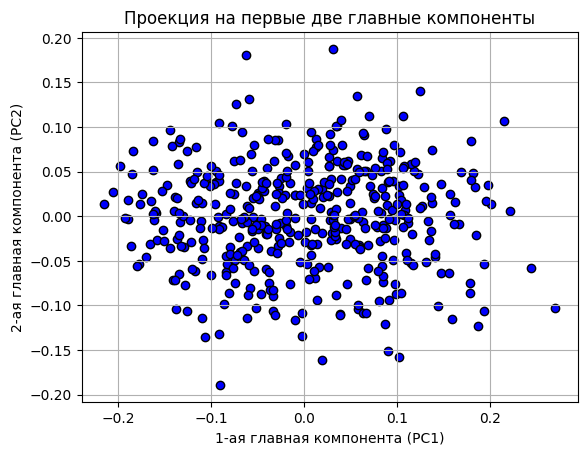

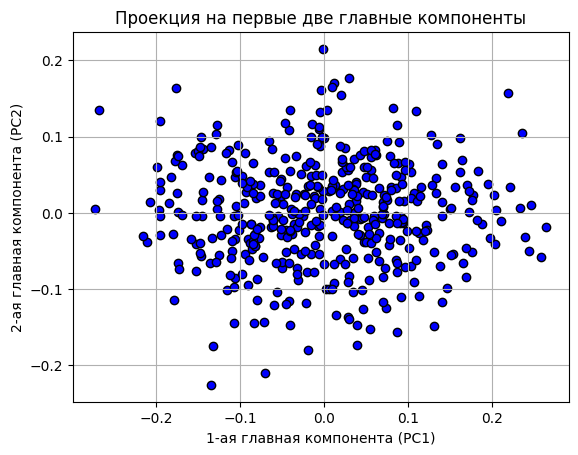

In [45]:
data = datasets.load_diabetes().data
data = Matrix([list(row) for row in data])
x_clean, var1, x_noisy, var2 = modified_add_noise_and_compare(data, noise_level=0.8, k=2)

## 4. Применение PCA к датасету

In [24]:
import csv

def modified_pca(X:'Matrix', k: int):
    m = len(X.matrix[0])
    n = len(X.matrix)
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)

    eigenvalues = qr_algorithm(C)
    eigenvalues_sorted = sorted(eigenvalues, reverse=True)
    eigenvectors = find_eigenvectors(C, eigenvalues_sorted)
    eigenvectors = [normalize_vector(v) for v in eigenvectors]

    k_principal = [[] for _ in range(m)]
    for i, vector in enumerate(eigenvectors):
        if i >= k:
            break
        for elem in range(m):
            k_principal[elem].append(vector[elem][0])

    k_principal = Matrix(k_principal)
    X_proj = X_centered @ k_principal
    explained_variance = explained_variance_ratio(eigenvalues, k)

    return X_proj, explained_variance, k_principal

def apply_pca_to_file(file_path: str, k: int):
    with open(file_path, 'r', newline='') as f:
        reader = csv.reader(f)
        next(reader)
        data = []
        for row in reader:
            if row:
                data.append([float(x) for x in row])

    X = Matrix(data)
    X_centered = center_data(X)
    X_proj, explained_variance, k_principal = modified_pca(X, k)

    X_recon = X_proj @ transpose(k_principal)
    mse = reconstruction_error(X_centered, X_recon)

    return X_proj, mse, explained_variance


In [27]:
X_proj, mse, variance = apply_pca_to_file('/heart.csv', 5)
print(f'MSE восстановленной матрицы: {mse}')
print(f'Доля объясненной дисперсии: {variance}')

MSE после восстановления матрицы: 0.23290017524922585
Доля объясненной дисперсии: 0.9990929026876236


In [29]:
from sklearn import datasets
from typing import Tuple

def apply_pca_to_dataset(dataset_name: str, k: int) -> Tuple['Matrix', float, float]:
    if dataset_name == 'iris':
        data = datasets.load_iris().data
    elif dataset_name == 'wine':
        data = datasets.load_wine().data
    elif dataset_name == 'digits':
        data = datasets.load_digits().data
    elif dataset_name == 'breast_cancer':
        data = datasets.load_breast_cancer().data
    elif dataset_name == 'diabetes':
        data = datasets.load_diabetes().data
    else:
        raise ValueError("Неизвестный датасет")

    X = Matrix([list(row) for row in data])

    X_centered = center_data(X)
    X_proj, explained_variance, k_principal = modified_pca(X, k)

    X_recon = X_proj @ transpose(k_principal)
    mse = reconstruction_error(X_centered, X_recon)

    return X_proj, mse, explained_variance


In [44]:
x, m, v = apply_pca_to_dataset('wine', 3)
print(f'MSE восстановленной матрицы: {m}')
print(f'Доля объясненной дисперсии: {v}')

MSE восстановленной матрицы: 0.5921999231817159
Доля объясненной дисперсии: 0.9999221050741537


# Математическое обоснование

### Доказать, что оптимальные направления PCA совпадают с собственными векторами матрицы ковариаций

##### Доказательсво:
Постановка задачи: пусть у нас есть Евклидово пространство размерности $D$ с определенным скалярным произведением $(x,y) = x^T  y$; пусть у нас есть матрица объектов-признаков. Задача состоит в том, чтобы спроецировать наши данные на пространство Размерности $M$, где $M<D$, и максимизировать дисперсию на новых осях пространства $M$ \
\
Перейдем к доказательству \
\
Пусть значение $M$ дано \
Для начала рассмотрим проекцию на одномерное пространство ($dim(M) = 1$). \
Пусть это пространство задается линейной оболочкой вектора $u$ такого, что $u^Tu = 1$ и $u \in \mathbb{R}^D$ \
Пусть $x_i$ - это наши векторы данных (объекты в матрице), $x_i \in \mathbb{R}^D$. Тогда проекция $x_i$ на наше подпространство будет представлять из себя скаляр равный $u^T  x_i$  \
\
Определим также среднее спроецированных данных на подпространство: $u^T  x_{mean}$, где $x_{mean} = \frac{1}{N} \sum_{n=1}^{N} x_n$; $X_{cen}$ - отцентрированная матрица X \
Центрирование данных нужно для того, чтобы можно было посмотреть чистый разброс данных, а не смещенный
\
Определим матрицу ковариаций: $C = \frac{1}{N-1} \sum_{n=1}^{N} (x_n - x_{mean})^T (x_n - x_{mean}) = \frac{1}{N-1} X_{cen}^TX_{cen}$ \
\
Зададим дисперсию спроектированных данных: $var = \frac{1}{N-1} \sum_{n=1}^{N} (u^T  x_n - u^T  x_{mean})^2 = u^T(\frac{1}{N-1} \sum_{n=1}^{N} (x_n - x_{mean})^T (x_n - x_{mean}))u = u^TCu$ \
\
Для метода PCA необходимо максимизировать дисперсию для выбора новой оси. Поэтому на векторе $u$ проекция данных должна иметь максимальную дисперсию \

Норму вектора $u$ оставим также равной 1, иначе если длина вектора $u$ будет стремиться к $\infty$, то и дисперсия будет стремиться к $\infty$, тогда нельзя будет сделать никакого вывода. \
\
Воспользуемся функцией Лагранжа: у нас есть целевая функция, которую мы исследуем $f(u) = u^TCu$ и функция ограничений $g(u) = 1 - u^Tu = 0$. \
Тогда $L(x, \lambda) = f(x) + \lambda * g(x)$, в нашем случае: $L(u, \lambda) = u^TCu + \lambda  (1 - u^Tu)$. Возьмем градиент по $u$ и получим $2Cu - 2\lambda u = 0$ \
Отсюда $Cu = \lambda u$, это и означает, что $\lambda$ - собственное значение матрицы ковариаций $C$. Так дисперсия будет максимальной, если $u$ будет являться собственным вектором соответствующим максимальному собственному значению $\lambda$. Это будет являться нашей первой главной компонентой. \
\
Мы можем определить дополнительные основные компоненты постепенно, выбирая каждое новое направление, которое максимизирует прогнозируемую дисперсию среди всех возможных направлений, ортогональных к тем, которые уже рассмотрены  
Следовательно, подпространство $M$ будет задаваться $M$ собственными векторами соответсвующими $M$ максимальным собственным значениям мактрицы ковариаций $C$

